In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import numpy as np

In [2]:
def path_link(path:str):
    sys.path.append(path)

path_link('master/code/lib')

import dataLoading as dl
from norm import normalizeGraph
import features as ft
import simulation as sim 

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

yessss


In [3]:
#PATH = 'master/code/runs1'
#PATH = 'master/code/runs2'
PATH = 'master/code/test_new_activation'


#DISPLAY_PATH = 'master/code/display_l1'
#DISPLAY_PATH = '/master/code/display_l1_2'
DISPLAY_PATH = 'master/code/display_l1_test_new_activation'

MODEL_PATH = 'master/code/models/mod_base'

In [4]:
def getErrors(model, loader):

    errorList = []

    vals = []

    with torch.no_grad():
        for data, _ in tqdm(loader):
            vals.extend(data.x.cpu().numpy().tolist())
            data.x = data.x[:, 2:]
            data = data.to(DEVICE)

            data = normalizeGraph(data)

            pred = model(data)

            pred = pred.cpu().detach().numpy()
            y = data.y.cpu().numpy()

            errorList.extend((np.sum((pred - y[:, 0, :])**2, axis = -1)).tolist())



    return errorList,vals

In [5]:
def getSim():
    lim = 0.85 * 100

    xPos = np.linspace(-lim, lim, 10)
    yPos = np.linspace(-lim, lim, 10)
    gridX, gridY = np.meshgrid(xPos, yPos)
    delta = np.random.uniform(0, 7, gridX.shape + (2,))

    gridX2 = gridX + delta[:, :, 0]
    gridY2 = gridY + delta[:, :, 1]

    pos = np.stack([gridX.ravel(), gridY.ravel()], axis=1)
    pos_perturbed = np.stack([gridX2.ravel(), gridY2.ravel()], axis=1)

    pos = np.concatenate([pos, pos_perturbed], axis=0)

    angles = np.random.rand(pos.shape[0]) * 2 * np.pi

    data = sim.compute_main(200, (60, 3.5, 70, 0.5), 120, T = 200, initialization = (pos, angles), dt = 0.001)[0]

    x, y, attr, inds = ft.processSimulation(data)

    return x, y, attr, inds


def getErrors(model):

    errorList = []
    errorList2 = []

    vals = []
    
    xList, yList, attrList, indsList = getSim()

    for t in range(len(xList)):
        vals.extend(xList[t].cpu().numpy().tolist())

        data= Data(x = xList[t][:, 2:], y = yList[t] , edge_attr = attrList[t], edge_index = indsList[t])

        data = normalizeGraph(data)
        data = data.to(DEVICE)

        pred = model(data)

        pred = pred.cpu().detach().numpy()
        y = data.y.cpu().numpy()

        errorList.extend((np.sum(np.abs(pred - y[:, 0, :])/(np.abs(y[:, 0, :])), axis = -1)).tolist())
        errorList2.append((np.sum(np.abs(pred - y[:, 0, :])/(np.abs(y[:, 0, :])), axis = -1)).tolist())


    return errorList,vals, errorList2



### =======

In [6]:
def findModels(path):
    pathLists = []
    for root, dirs, files in tqdm(os.walk(path)):
            for file in files:
                  
                  if file.endswith('.pt'):
                        pathLists.append(os.path.join(root, file))


    return pathLists


def delete_wandb_dirs(start_path):
    for root, dirs, files in os.walk(start_path, topdown=False):
        for dir_name in dirs:
            if dir_name == "wandb":
                dir_path = os.path.join(root, dir_name)
                print(f"Deleting: {dir_path}")
                shutil.rmtree(dir_path)


def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader


def getName(path):
    run_name = path.split('/')[-3]

    model_type = path.split('/')[-1].split('.')[0]

    if 'best' in model_type:
        model_type = '_best'

    else:
         model_type = '_latest'

    name = run_name + model_type

    return name


def getModelName(key):

    name = ''

    #if 'simplest' in key:
    #    name = name + 'simplest'
    
    name = name + 'simplest'

    ## other possibilities

    if 'no-dropout' in key:
        name = name + '_no-dropout'
    else:
        name = name + '_dropout'

    if 'no-encoder' in key:
        name = name + '_no-encoder'
    else:
        name = name + '_encoder'

    if 'relu' in key:
        name = name + '-relu'

    return name
         

def loadModel(modelName:str, inputShape:int = 8, edges_shape = 5, path = None):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    model = loadFun.loadNetwork(inputShape, edges_shape)

    return model



def findLoader(key):

    # remains initial conditions to consider
    if 'normal' in key:
        if '0_01' in key:
            dataloader_path = '/master/code/simulation/path/mew_0_01_normal.json'

        else:       # 0.001
            dataloader_path = '/master/code/simulation/path/mew_0_001_normal.json'

    else:       # noisy
        if '0_01' in key:
            dataloader_path = '/master/code/simulation/path/mew_0_01_noisy.json'

        else:       # 0.001
            dataloader_path = '/master/code/simulation/path/mew_0_001_noisy.json'

    print(dataloader_path)


    return getLoader(None, 128, True, None, dataloader_path, 'test')


def plotModels(modelList, pathPlot = DISPLAY_PATH):
    
    nb = 0
    with torch.no_grad():
        # get the data for the different models

        for model_path in tqdm(modelList):
            # find name that identify the model
            name_plot = getName(model_path)

            # load model
            try:
                model = loadModel(getModelName(name_plot), path=MODEL_PATH)
                std_dict = torch.load(model_path)
                model.load_state_dict(std_dict)
                model.eval()

                # condition loader on the dt
                loader = findLoader(model_path)

                # get data
                for data, _ in loader:
                    break

                # get messages
                message = model.message(data).cpu().detach().numpy()

                # plot the message
                plotStdMessage(message)

                path = os.path.join(pathPlot, f"{name_plot}.png")

                nb_plot = 0
                while os.path.exists(path):
                    nb_plot += 1
                    path = os.path.join(pathPlot, f"{name_plot}_{nb_plot}.png")

                plt.savefig(path)
                plt.close()

            except:
                print(f'Issue >>> {nb}')
                nb += 1

In [7]:
model_list = findModels(PATH)
loader = findLoader(model_list[])

0it [00:00, ?it/s]

14it [00:00, 81.31it/s]

/master/code/simulation/path/mew_0_001_normal.json


In [52]:
model_path = model_list[4]

name_plot = getName(model_path)
try:
    model = loadModel(getModelName(name_plot), path=MODEL_PATH)
    std_dict = torch.load(model_path)
    model.load_state_dict(std_dict)
    model = model.to(DEVICE)
    model.eval()
except:
    print("njfngkvjsdn")

>>>> loading simplest
INFO >>> relu end of message MLP
INFO >>> with NO encoder
INFO >>> with NO dropout


In [53]:
#errors, vals = getErrors(model, loader)
errors, vals, error2 = getErrors(model)

v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:02<00:00, 85.64it/s] 


In [54]:
errors = np.array(errors)
vals = np.array(vals)

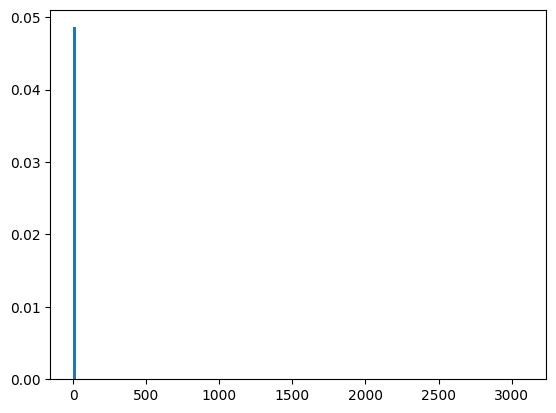

In [55]:
plt.hist(errors, density = True, bins = 150)
plt.show()

In [56]:
print(np.median(errors))

0.03828274644911289


In [57]:
print(vals.shape)

(37800, 10)


In [58]:
speeds = np.sqrt(vals[:, 2]**2 + vals[:, 3]**2)

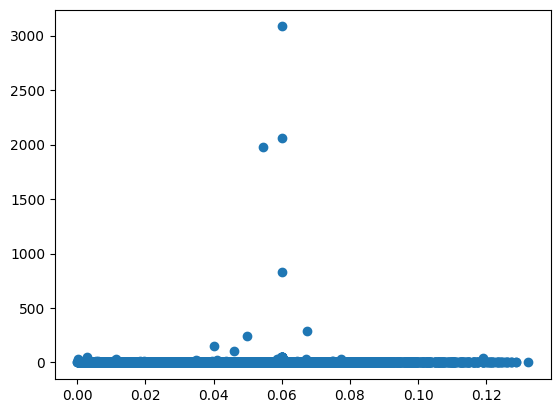

In [59]:
plt.scatter(speeds, errors)
plt.show()

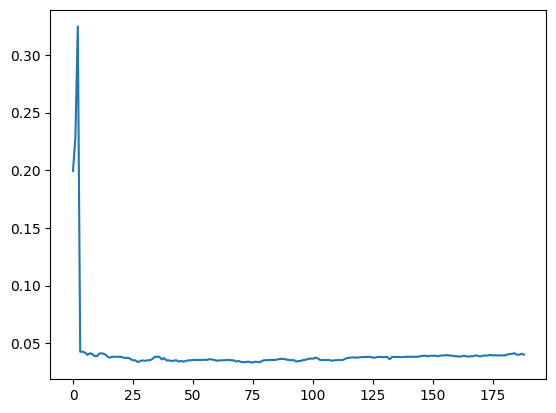

In [60]:
def plotErrorTime(errorTime):
    vals = [np.median(errorTime[i]) for i in range(len(errorTime))]
    plt.plot(vals)
    plt.show()

plotErrorTime(error2)

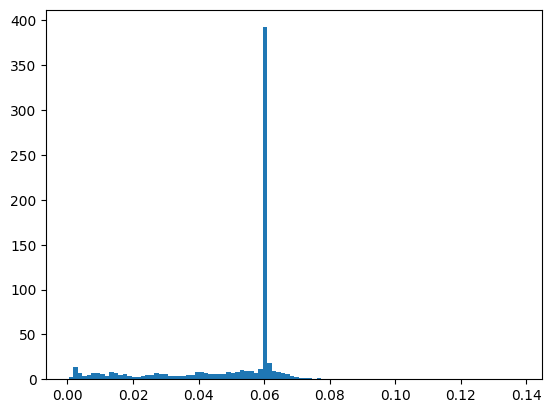

In [42]:
plt.hist(speeds, density = True, bins = 100)
plt.show()

In [ ]:
plt.boxplot(vals[:, 2]**2 + vals[:, 3]**2)
plt.show()

In [61]:
print(y[0][:, 0, :])

tensor([[-0.0600,  0.0017],
        [ 0.0567,  0.0196],
        [ 0.0278, -0.0532],
        [-0.0454,  0.0393],
        [ 0.0476,  0.0365],
        [ 0.0592, -0.0101],
        [-0.0496,  0.0338],
        [ 0.0232, -0.0554],
        [-0.0409, -0.0439],
        [-0.0011,  0.0600],
        [-0.0373, -0.0265],
        [ 0.0716,  0.0601],
        [-0.0598, -0.0052],
        [ 0.0292, -0.0022],
        [-0.0506, -0.0323],
        [-0.0018,  0.0866],
        [-0.0289,  0.0151],
        [-0.0216,  0.0560],
        [ 0.0577, -0.0164],
        [ 0.0275, -0.0533],
        [ 0.0408, -0.0199],
        [ 0.0561,  0.0212],
        [ 0.0483,  0.0356],
        [ 0.0324,  0.0505],
        [ 0.0361, -0.0507],
        [ 0.0293, -0.0523],
        [ 0.0596, -0.0067],
        [-0.0527,  0.0286],
        [ 0.0051, -0.0598],
        [-0.0319, -0.0508],
        [-0.0437, -0.0411],
        [-0.0599, -0.0038],
        [-0.0307, -0.0516],
        [ 0.0594, -0.0084],
        [-0.0600,  0.0023],
        [-0.0409,  0